# AMPSphere v.2022-03

This is a notebook meant to form the set of notebooks used to analyze the data in AMPSphere and write the manuscript:

__AMPSphere: Global survey of prokaryotic antimicrobial peptides shaping microbiomes__

Figures generated in this script formed the panel shown in Figure 1B.

### Comparison of c_AMPs and other validated proteins

Here we show the quality of homologs distributed by database.


In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import hypergeom

In [20]:
# load data
dramp = pd.read_table('data/dramp_candidates.txt.gz', header=None)
smprot = pd.read_table('data/SmProt_candidates.txt.gz', header=None)
starpep = pd.read_table('data/starPepDB_candidates.txt.gz', header=None)
storfs = pd.read_table('data/STsORFs_candidates.txt.gz', header=None)
gmgc = pd.read_table('data/gmgc_candidates.txt.gz', header=None)

In [3]:
# proportion of quality candidates
q = pd.read_table('data/high_quality_candidates.txt.gz', header=None)
qq = pd.read_table('data/quality_candidates.txt.gz', header=None)
q = pd.concat([q, qq])
q = set(q[0])

qualprop = []
for k in [starpep, dramp, smprot, gmgc]:
    n1 = len(set(k[0]).intersection(q))
    qualprop.append(n1)

([<matplotlib.patches.Wedge at 0x7f0548650a00>,
 [Text(-1.0606143793710532, 0.291714137935335, 'Unknown candidates'),
  Text(1.15703386095599, -0.3182336321026974, 'Homologs')],
 [Text(-0.5785169342023926, 0.1591168025101827, '91%'),
  Text(0.6749364188909942, -0.18563628539324015, '9%')])

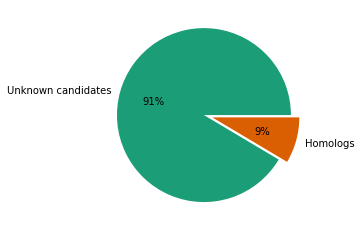

In [4]:
# generate 1st graph
total_amps = 863_498
homologs = pd.concat([dramp, smprot, starpep, storfs, gmgc])
homologs = set(homologs[0])
data = [total_amps - len(homologs), len(homologs)]
classes = ['Unknown candidates', 'Homologs']
explode = [0, 0.1]

palette_color = sns.color_palette('Dark2')
plt.pie(data,
        labels=classes,
        colors=palette_color,
        explode=explode,
        autopct='%.0f%%')

In [5]:
# generate 2nd graph
data = [len(dramp), len(smprot), len(starpep), len(storfs), len(gmgc)]
classes = ['DRAMP v3', 'SmProt2', 'StarPepDB45k', 'STsORFs', 'GMGC v1']
data = pd.DataFrame(data, index=classes)
data = data.sort_values(by=0)
data = data.drop('STsORFs', axis=0)

data['high_quality'] = qualprop
data.rename({0: 'total AMP candidates'}, axis=1, inplace=True)
data['other'] = data['total AMP candidates'] - data['high_quality']

pq = len(q) / 863498
data['prop_ampsphere'] = data['total AMP candidates'] * pq

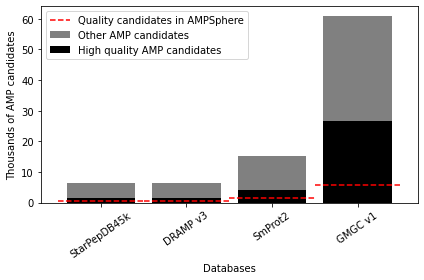

In [6]:
fig, ax = plt.subplots()
sns.barplot(ax=ax,
            data=data/1000,
            y='total AMP candidates',
            x=data.index,
            color='gray',
            label='Other AMP candidates')

sns.barplot(ax=ax,
            data=data/1000,
            y='high_quality',
            x=data.index,
            color='black',
            label='High quality AMP candidates')

ax.set_xlabel('Databases')
ax.set_ylabel('Thousands of AMP candidates')
ax.set_xticklabels(data.index, rotation=35)

for i, c in enumerate(data.prop_ampsphere):
    if i == 0:
        ax.hlines(y=c/1000, xmin=i-0.5,
                  xmax=i+0.5, linestyles='dashed',
                  color='red', label='Quality candidates in AMPSphere')
    else:
        ax.hlines(y=c/1000, xmin=i-0.5,
                  xmax=i+0.5, linestyles='dashed',
                  color='red')

plt.legend()
plt.tight_layout()

In [9]:
# calculate enrichment
m = len(set(dramp[0]).intersection(q))
M = len(dramp)
n = len(q)
N = 863_498
p = hypergeom.sf(m, N, n, M)
e = (m*N)/(n*M)

print(f'''Enrichment of quality candidates among the c_AMPs homologs to DRAMP v.3.0

Proportion of quality candidates among the annotated: {m*100/M}
Proportion of quality candidates among the AMPSphere: {n*100/N}
Enrichment: {e} fold
p-value: {p}''')

Enrichment of quality candidates among the c_AMPs homologs to DRAMP v.3.0

Proportion of quality candidates among the annotated: 23.599936898564444
Proportion of quality candidates among the AMPSphere: 9.289309297763284
Enrichment: 2.540548079742261 fold
p-value: 4.220811718840738e-250


In [10]:
def getproportions(amps, quality):
    '''
    Get percent of passing AMPs per test
    in a given set of AMPs
    
    :inputs:
    amps - list of amps
    quality - pandas dataframe with the
              quality assessment per AMP
    
    :output:
    dataframe with the index as different quality
    tests and the percent of homologs passing the
    tests
    '''
    dftmp = quality[quality.AMP.isin(amps)]
    dftmp = dftmp.drop('AMP', axis=1)
    dftmp = dftmp.replace('Passed', 1)
    dftmp = dftmp.replace('Failed', 0)
    dftmp = dftmp.replace('Not tested', 0)
    return dftmp.sum(axis=0) * 100 / len(amps)

In [23]:
# determine the proportion of AMPs passing each test
# by homologs sets identified with different dbs
qual = pd.read_table('data/quality_assessment.tsv.gz')

dramp = getproportions(dramp[0], qual)
gmgc = getproportions(gmgc[0], qual)
smprot = getproportions(smprot[0], qual)
starpep = getproportions(starpep[0], qual)
storfs = getproportions(storfs[0], qual)

In [24]:
# formatting data frame
df = pd.concat([dramp,
                gmgc,
                smprot,
                starpep,
                storfs],
               axis=1)

df.columns = ['DRAMP v3.0', 'GMGC v1',
              'SmProt 2', 'starPep45k',
              'STsORFs']

df = df.reset_index()
df = df.rename({'index': 'Quality test'}, axis=1)
df

,Quality test,DRAMP v3.0,GMGC v1,SmProt 2,starPep45k,STsORFs
0,Antifam,100.000000,99.429695,100.000000,100.000000,100.000000
1,RNAcode,92.869538,43.623402,85.193175,92.830912,63.636364
2,metaproteomes,9.717621,3.397247,10.492253,9.771675,0.000000
3,metatranscriptomes,11.926171,22.781055,19.768582,12.022992,36.363636
4,Coordinates,27.086291,100.000000,34.882657,27.031774,72.727273


In [25]:
# determined general parameters in the entire AMPSphere
ampsphere_limits = getproportions(qual.AMP.tolist(), qual).to_dict()
ampsphere_limits

{'Antifam': 99.95043416429453,
 'RNAcode': 24.947481059597127,
 'metaproteomes': 0.9980335796956101,
 'metatranscriptomes': 19.314346993276185,
 'Coordinates': 68.39726322469768}

In [26]:
x = df.melt(id_vars=['Quality test'], value_vars=df.columns[1:])

x.rename({'value': '% of homologs',
          'variable': 'Database'},
         axis=1,
         inplace=True)

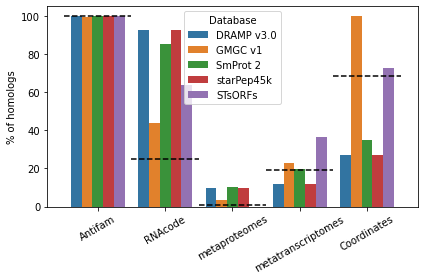

In [28]:
# plot
fig, ax = plt.subplots()
sns.barplot(x='Quality test', y='% of homologs', hue='Database', data=x)

# iterate over range of number of rows
for i, c in enumerate(ampsphere_limits):
    ax.hlines(y=ampsphere_limits[c], xmin=i-0.5,
              xmax=i+0.5, linestyles='dashed',
              color='black')

plt.xlabel('')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.tight_layout()

In [29]:
qual['Experimental evidence'] = 'Failed'
a, b = (qual.metaproteomes == 'Passed'), (qual.metatranscriptomes == 'Passed')
qual.loc[a | b, 'Experimental evidence'] = 'Passed'
qual.drop(['metaproteomes', 'metatranscriptomes'], axis=1, inplace=True)

In [32]:
# counting amps per class
expevd = qual['Experimental evidence'].value_counts()
antifam = qual.Antifam.value_counts()
rna = qual.RNAcode.value_counts()
terminal = qual.Coordinates.value_counts()

In [33]:
df = pd.concat([antifam, terminal, expevd, rna], axis=1).fillna(0)
df.columns = ['Antifam', 'Terminal placement', 'Experimental evidence', 'RNAcode']
df = df.T
df

,Passed,Failed,Not tested
Antifam,863070.0,428.0,0.0
Terminal placement,590609.0,272889.0,0.0
Experimental evidence,172840.0,690658.0,0.0
RNAcode,215421.0,188167.0,459910.0


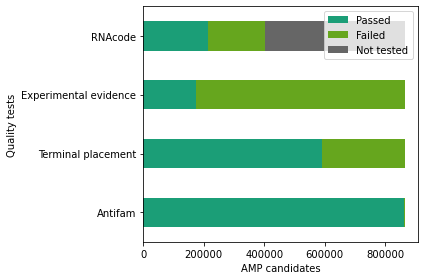

In [34]:
df.plot.barh(stacked=True, cmap='Dark2')
plt.xlabel('AMP candidates')
plt.ylabel('Quality tests')
plt.tight_layout()